In [1]:
# Virtual Environment: Python 3.10
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Configure precision
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_rows', 15)

print("Imports complete. Product: EcoProphet MVP.")

Imports complete. Product: EcoProphet MVP.


In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"

try:
    df = pd.read_excel(url)
# In case the URL does not work due to network issues or webpage errors
except:
    df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SideProject-EcoProphet/ENB2012_data.xlsx')

# Rename columns for business readability
column_map = {
    'X1': 'Relative_Compactness',
    'X2': 'Surface_Area',
    'X3': 'Wall_Area',
    'X4': 'Roof_Area',
    'X5': 'Overall_Height',
    'X6': 'Orientation',
    'X7': 'Glazing_Area',
    'X8': 'Glazing_Area_Distribution',
    'Y1': 'Heating_Load',
    'Y2': 'Cooling_Load'
}
df = df.rename(columns=column_map)

# Focus on Heating Load for this MVP sprint
dataset = df.drop(columns=['Cooling_Load'])

In [3]:
# Inspect the data structure
print(dataset.head())
print(dataset.describe())

   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98        514.50     294.00     110.25            7.00   
1                  0.98        514.50     294.00     110.25            7.00   
2                  0.98        514.50     294.00     110.25            7.00   
3                  0.98        514.50     294.00     110.25            7.00   
4                  0.90        563.50     318.50     122.50            7.00   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  
0            2          0.00                          0         15.55  
1            3          0.00                          0         15.55  
2            4          0.00                          0         15.55  
3            5          0.00                          0         15.55  
4            2          0.00                          0         20.84  
       Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  \
count                768.0

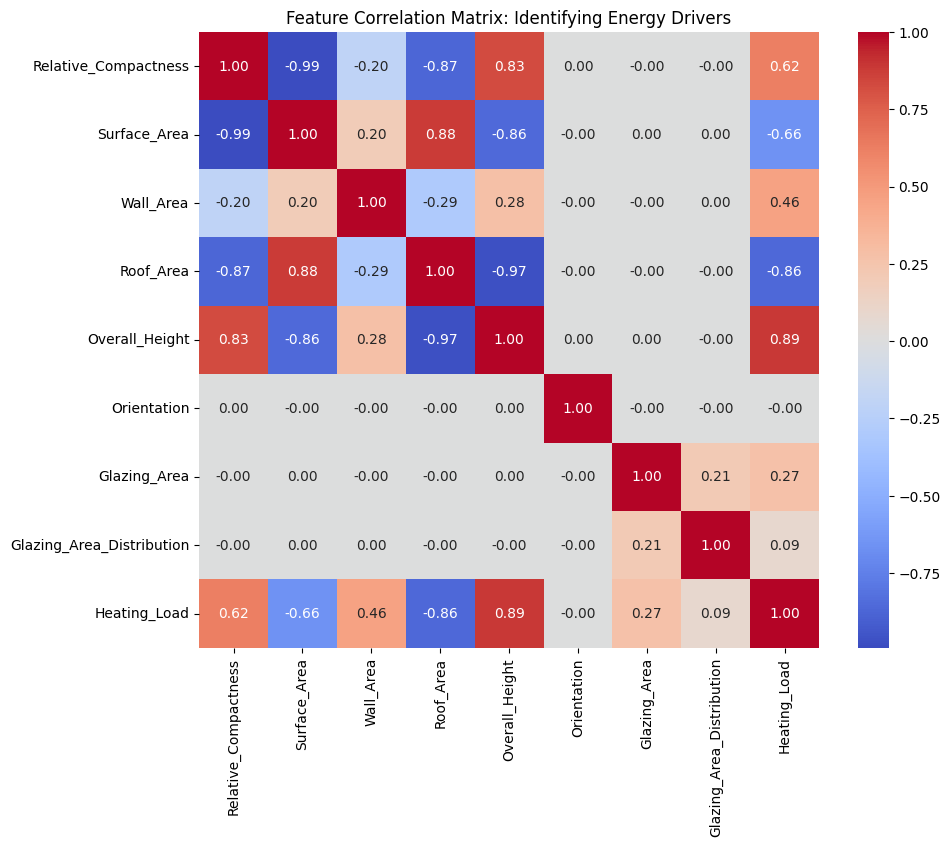

In [4]:
# Visualization of Feature Correlations
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix: Identifying Energy Drivers")
plt.show()

# Insight:
# 'Overall_Height' has a strong positive correlation (0.89) with Heating Load.
# 'Roof_Area' has a strong negative correlation (-0.86).
# Business implication: Taller buildings with smaller roofs are more efficient in this dataset.

In [5]:
# Split features and labels
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Heating_Load')
test_labels = test_features.pop('Heating_Load')

# The Normalization Layer (Crucial for converging models with different units like Area vs. Ratio)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [6]:
# Build the Model (Single Dense Layer = Linear Regression)

# Hyperparameters
my_learning_rate = 0.1

model = tf.keras.Sequential([
    normalizer, # Use the previously adapted normalizer layer
    tf.keras.layers.Dense(units=1) # A single dense layer for linear regression
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [7]:
# Training the Model

# Add EarlyStopping callback to optimize training time and prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

history = model.fit(
    train_features,
    train_labels,
    epochs=50, # Set a higher number of epochs, as EarlyStopping will manage when to stop
    batch_size=32,
    verbose=1, # Change verbose to 1 to see the training progress
    validation_split=0.2,
    callbacks=[early_stop] # Add the callback to the training process
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 528.2518 - mean_absolute_error: 21.7367 - mean_squared_error: 528.2518 - val_loss: 427.9407 - val_mean_absolute_error: 20.2157 - val_mean_squared_error: 427.9407
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 412.6059 - mean_absolute_error: 19.7770 - mean_squared_error: 412.6059 - val_loss: 362.9904 - val_mean_absolute_error: 18.7431 - val_mean_squared_error: 362.9904
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 345.7942 - mean_absolute_error: 18.1597 - mean_squared_error: 345.7942 - val_loss: 307.6407 - val_mean_absolute_error: 17.2674 - val_mean_squared_error: 307.6407
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 297.1978 - mean_absolute_error: 16.7801 - mean_squared_error: 297.1978 - val_loss: 256.2120 - val_mean_absolute_error: 15.7105 - val_mean_squared_error: 256.2120
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.5570 - mean_absolute_error: 14.9144 - mean_squared_err

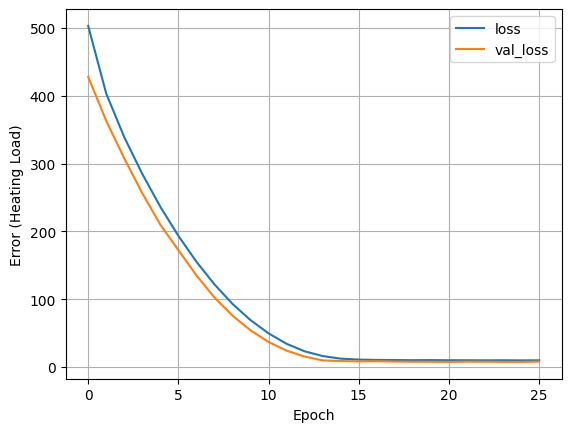

In [8]:
# Visualize Loss to prove convergence
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error (Heating Load)')
    plt.legend()
    plt.grid(True)

plot_loss(history)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Mean Absolute Error on Test Set: 2.00 kWh/m²
R2 Score on Test Set: 0.92
Root Mean Squared Error on Test Set: 2.82 kWh/m²


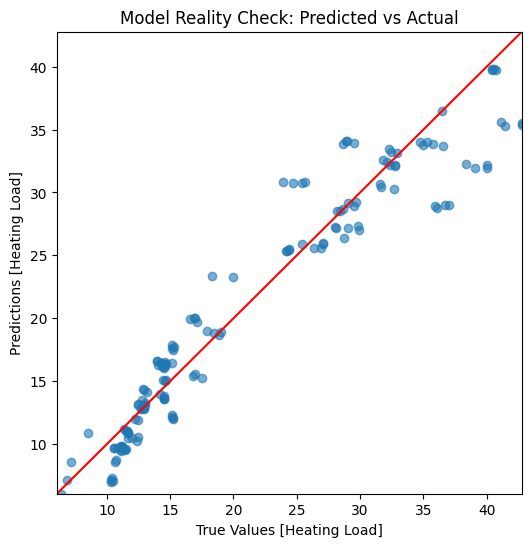

In [9]:
from sklearn.metrics import r2_score

test_results = model.evaluate(test_features, test_labels, verbose=0)

# Prediction Plot
test_predictions = model.predict(test_features).flatten()

# Calculate MAE metrics
print(f"\nMean Absolute Error on Test Set: {test_results[1]:.2f} kWh/m²")

# Calculate eval metrics
r2 = r2_score(test_labels, test_predictions)
print(f"R2 Score on Test Set: {r2:.2f}")

# Calculate RMSE (Root Mean Squared Error) from MSE
rmse = np.sqrt(test_results[2]) # test_results[2] is the mean_squared_error
print(f"Root Mean Squared Error on Test Set: {rmse:.2f} kWh/m²")

plt.figure(figsize=(6, 6))
plt.scatter(test_labels, test_predictions, alpha=0.6)
plt.xlabel('True Values [Heating Load]')
plt.ylabel('Predictions [Heating Load]')
lims = [min(test_labels.min(), test_predictions.min()), max(test_labels.max(), test_predictions.max())]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, color='red') # The "Perfect Prediction" line
plt.title("Model Reality Check: Predicted vs Actual")
plt.show()



In my blog/article, the modeling should have ended here, but I added a couple of analysis down below for additional insights. Feel free to (optionally) skip it!

In [10]:
# Access the Dense layer (index 1, as index 0 is the Normalization layer)
dense_layer = model.layers[1]

# Get the weights and bias
weights, bias = dense_layer.get_weights()

print("\n--- Model Weights and Bias ---")
print(f"Coefficients (Weights):\n{weights.flatten()}")
print(f"Bias: {bias[0]:.4f}")

print("\nThis model is indeed a multi-linear regression because the Dense layer with a single unit learns a linear relationship between the input features and the output (Heating_Load).")



--- Model Weights and Bias ---
Coefficients (Weights):
[-2.8256338  -1.6051543   1.8784871  -1.7991513   7.5130625   0.01221415
  2.9008238   0.13841699]
Bias: 22.4992

This model is indeed a multi-linear regression because the Dense layer with a single unit learns a linear relationship between the input features and the output (Heating_Load).



--- Feature Influence (Sorted by Absolute Weight) ---
                     Feature  Weight  Absolute_Weight
4             Overall_Height    7.51             7.51
6               Glazing_Area    2.90             2.90
0       Relative_Compactness   -2.83             2.83
2                  Wall_Area    1.88             1.88
3                  Roof_Area   -1.80             1.80
1               Surface_Area   -1.61             1.61
7  Glazing_Area_Distribution    0.14             0.14
5                Orientation    0.01             0.01


/tmp/ipython-input-3400090605.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_Weight', y='Feature', data=weights_df, palette='viridis')


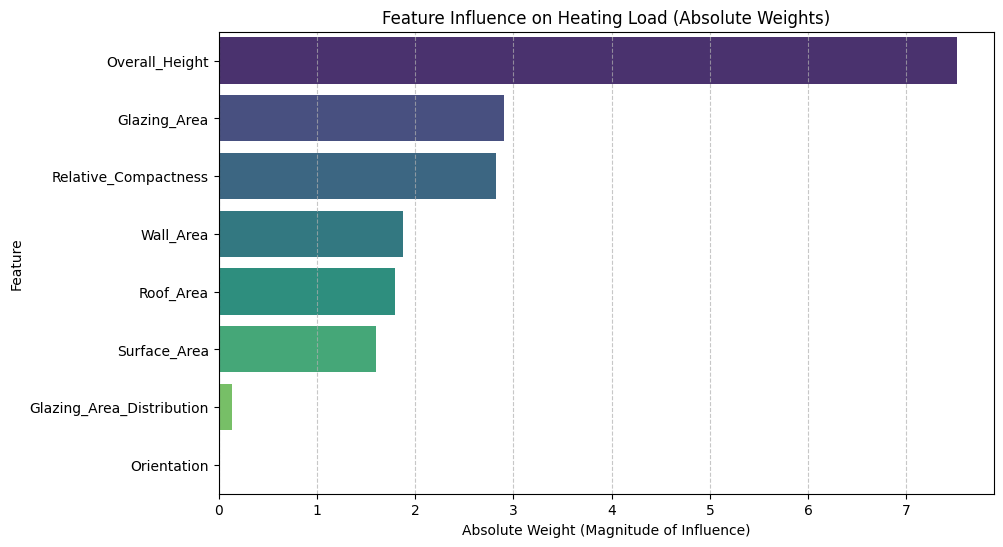

In [11]:
# Get feature names from the training data
feature_names = train_features.columns

# Create a DataFrame to combine feature names and their weights
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights.flatten() # Flatten the weights array for easier handling
})

# Calculate absolute weights to show magnitude of influence
weights_df['Absolute_Weight'] = np.abs(weights_df['Weight'])

# Sort by absolute weight to see the most influential features first
weights_df = weights_df.sort_values(by='Absolute_Weight', ascending=False)

print("\n--- Feature Influence (Sorted by Absolute Weight) ---")
print(weights_df)

# Visualize the feature influence
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute_Weight', y='Feature', data=weights_df, palette='viridis')
plt.title('Feature Influence on Heating Load (Absolute Weights)')
plt.xlabel('Absolute Weight (Magnitude of Influence)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()